In [49]:
device = 'cuda'if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [50]:
import numpy as np

def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, var 5 years, min age 18
             mean ARPU 100, var 15
    Class 2: mean age 45, var 6 years
             mean ARPU 50, var 25
    """
    if ctype is None:
        if np.random.random() > .5: #coin toss
            ctype = 1
        else:
            ctype = 2
    age = 0
    ft = -1
    if ctype == 1:
        while age < 18:
            age = np.random.normal(25, 5)
        while ft < 0:
            ft = np.random.normal(100, 15)
    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
        while ft < 0:
            ft = np.random.normal(50, 25)
    age = round(age)
    return ctype, (age, ft)

def get_rewards(customer):
    """
    There are three actions:
    promo 1: low value. 10 dollar if accept
    promo 2: mid value. 25 dollar if accept
    promo 3: high value. 100 dollar if accept
    Both groups are unlikely to accept promo 2.
    Group 1 is more likely to accept promo 1.
    Group 2 is slightly more likely to accept promo 3.
    The optimal choice for group 1 is promo 1; 90% acceptance for
    an expected reward of 9 dollars each.
    Group 2 accepts with 25% rate for expected 2.5 dollar reward
    The optimal choice for group 2 is promo 3; 20% acceptance for an expected
    reward of 20 dollars each.
    Group 1 accepts with 2% for expected reward of 2 dollars.
    The least optimal choice in all cases is promo 2; 10% acceptance rate for both groups
    for an expected reward of 2.5 dollars.
    """
    if customer[0] == 1: #group 1 customer
        if np.random.random() > .1:
            reward1 = 10
        else:
            reward1 = 0
        if np.random.random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if np.random.random() > .98:
            reward3 = 100
        else:
            reward3 = 0
    if customer[0] == 2: #group 2 customer
        if np.random.random() > .75:
            reward1 = 10
        else:
            reward1 = 0
        if np.random.random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if np.random.random() > .80:
            reward3 = 100
        else:
            reward3 = 0
    return np.array([reward1, reward2, reward3])

def generate_data(n_rows):
    contexts = []
    actions = []
    rewards = []
    opt_actions = []
    reward_vectors = []
    for i in range(n_rows):
        ctype, (age, ARPU) = get_customer()
        reward_vector = get_rewards((ctype, (age, ARPU)))
        action = np.random.randint(0,3)
        reward = reward_vector[action]
        if ctype == 1:
            user_id = np.random.randint(0,20)
            opt_action = 0
        else:
            user_id = np.random.randint(20,40)
            opt_action = 2
        contexts.append([user_id, age, ARPU])
        actions.append(action)
        rewards.append(reward)
        opt_actions.append(opt_action)
        reward_vectors.append(reward_vector)
    return np.array(contexts), np.array(actions), np.array(rewards), np.array(opt_actions), np.array(reward_vectors)




In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import numpy as np
import time

class W_D(nn.Module):
    def __init__(self,         
                 deep_in_dim=63, 
                 action_dim=3, 
                 num_embedding=100, 
                 embed_dim=16, 
                 deep_neurons=[32, 16], 
                 activation=nn.ReLU()):
        
        super(W_D, self).__init__()
        self.context_dim = 1 + deep_in_dim
        self.action_dim = action_dim
        self.z_dim = embed_dim + deep_neurons[-1]
        self.activation = activation
        
        self.wide = nn.Embedding(num_embedding, embed_dim)
        
        deep_dict = OrderedDict([])
        in_features = deep_in_dim
        for i, out_features in enumerate(deep_neurons):
            deep_dict[f"fc{i}"] = nn.Linear(in_features, out_features)
            deep_dict[f"activation{i}"] = activation
            in_features = out_features

        self.deep = nn.Sequential(deep_dict)
        # define the final layer
        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)
        
    def forward(self, x):
        
        z = self.get_z(x)
        out = self.activation(self.lastlayer(z))
        return out
    
    def get_z(self, x):
        w_in = x[:,0].long()
        w_out = self.wide(w_in)
        d_in = x[:,1:]
        d_out = self.deep(d_in)
        z = torch.cat((w_out, d_out),dim=1)
        return z
        

class ContextualBandit():
    
    def __init__(self, device, model, optimizer, loss_func, algorithm):
        self.device = device
        self.model = model.to(device)
        self.context_dim = model.context_dim
        self.z_dim = model.z_dim
        self.action_dim = model.action_dim
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.algorithm = algorithm
        self.reset()
        
    def reset(self):
        self.dataset = []
    
    def observe_data(self, context_source):
        x_t = np.array(context_source)
        assert x_t.shape == (self.action_dim, self.context_dim)
        return x_t 
    
    def get_reward(self, reward_source, a_t):
        r_t = float(reward_source[a_t])
        return r_t

    def run(self, context_source, reward_source):
        x_t = self.observe_data(context_source) # x_t np.array size=(action_dim, context_dim)
        x_t_tensor = torch.tensor(x_t).float().to(self.device)
        z_t = self.model.get_z(x_t_tensor).detach().cpu().numpy() # z_t np.array size=(action_dim, context_dim)
        a_t = self.algorithm.select_action(z_t) # a_t int range (0, action_dim)
        r_t = self.get_reward(reward_source, a_t) # r_t float either from an online simulation or from a reward vertor(size=action_dim)  
        data = (x_t[a_t], z_t[a_t], a_t, r_t)
        self.dataset.append(data)
        self.algorithm.update(data) # update selection strategy (parameters of algorithm)
        
        return a_t
    
    def train(self, start_index=0, batch_size=16, num_epoch=100):
        # prepare dataset and dataloader for training
        train_dataset = BanditDataset(self.dataset[start_index:])
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        # train num_epoch epoches
        for i in range(num_epoch):
            for data_batch in train_dataloader:
                contexts, _, actions, rewards = data_batch
                contexts = contexts.float().to(self.device)
                actions = actions.long().to(self.device)
                rewards = rewards.float().to(self.device)
                outputs = model(contexts)
                pred_rewards = outputs[range(outputs.shape[0]),actions]
                loss = self.loss_func(pred_rewards, rewards)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()                
        # update algorithm's parameters after training
        self.algorithm.reset()
        for data in self.dataset:
            x_t_a_t, _, a_t, r_t = data
            x_t_a_t_tensor = torch.tensor(x_t_a_t).float().unsqueeze(0).to(self.device)
            with torch.no_grad():
                z_t_a_t = self.model.get_z(x_t_a_t_tensor).detach().cpu().numpy().reshape(-1)
            self.algorithm.update((x_t_a_t, z_t_a_t, a_t, r_t))
    
class BanditDataset(torch.utils.data.Dataset):
    
    def __init__(self, raw_dataset):
        self.dataset = raw_dataset
        
    def __getitem__(self, index):
        context, z, action, reward = self.dataset[index]
        return np.array(context), np.array(z), action, reward
    
    def __len__(self):
        return len(self.dataset)
    
class LinUCB():
    
    def __init__(self, z_dim, action_dim, delta=0.05):
        self.action_dim = action_dim
        self.z_dim = z_dim
        self.alpha = 1.0 + np.sqrt(np.log(2 / delta) / 2)
        self.reset()
    
    def reset(self):
        self.A = [np.eye(self.z_dim) for i in range(self.action_dim)]
        self.b = [np.zeros(self.z_dim) for i in range(self.action_dim)]
    
    def select_action(self, z_t):
        theta = np.zeros((self.action_dim, self.z_dim))
        ucb = np.zeros(self.action_dim)
        for a in range(self.action_dim):
            A_inv = np.linalg.inv(self.A[a])
            theta[a] = np.dot(A_inv, self.b[a])
            ucb[a] = np.dot(z_t[a], theta[a]) + self.alpha * np.sqrt(np.dot(np.dot(z_t[a], A_inv), z_t[a]))
        
        return np.argmax(ucb)
    
    def update(self, data):
        _, z_t_a_t, a_t, r_t = data
        assert z_t_a_t.shape == (self.z_dim, )
        assert type(a_t) == np.int64
        assert type(r_t) == float
        self.A[a_t] += np.dot(z_t_a_t.reshape((self.z_dim, 1)), z_t_a_t.reshape((1, self.z_dim)))
        self.b[a_t] += r_t * z_t_a_t
    
    
class TS():
    
    def __init__(self, ):
        pass
    
    def reset(self, ):
        pass
    
    def select_action(self, ):
        pass
    
    def update(self, ):
        pass


In [52]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = W_D(deep_in_dim=2, action_dim=3, num_embedding=40, deep_neurons=[128, 64]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm = LinUCB(model.z_dim, model.action_dim, delta=0.05)
CB = ContextualBandit(device, model, optimizer, loss_func, algorithm)

train_batch_size = 64
num_epoch = 100

num_data_train = 10240
data_train = generate_data(num_data_train)
num_data_valid = 1024
data_valid = generate_data(num_data_valid)

#num_data = 100000
#contexts = np.random.random(size=(num_data, model.context_dim))
#reward_vectors = np.random.random(size=(num_data, model.action_dim))

contexts, _, _, opt_actions, reward_vectors = data_train

train_start_index = 0
start_time = time.time()
pred_actions = []
for t in range(num_data_train):
    context_source = np.array([contexts[t] for i in range(model.action_dim)])
    reward_source = reward_vectors[t]
    pred_a = CB.run(context_source, reward_source)
    pred_actions.append(pred_a)
    if (t+1)%1024 == 0:
        CB.train(start_index=train_start_index, batch_size=train_batch_size, num_epoch=num_epoch)
        train_start_index = t + 1
        print("{} --- {} seconds ---".format(t+1,(time.time() - start_time)))
        start_time = time.time()

cum_rewards_pred_action = []
cum_rewards_opt_action = []
p_i = 0
o_i = 0
for i in range(num_data_train):
    p_i += reward_vectors[i][pred_actions[i]]
    o_i += reward_vectors[i][opt_actions[i]]
    cum_rewards_pred_action.append(p_i)
    cum_rewards_opt_action.append(o_i)

1024 --- 6.898706674575806 seconds ---
2048 --- 7.200937986373901 seconds ---
3072 --- 7.684576511383057 seconds ---
4096 --- 8.263684034347534 seconds ---
5120 --- 8.450798511505127 seconds ---
6144 --- 8.8772611618042 seconds ---
7168 --- 9.34550929069519 seconds ---
8192 --- 9.978452205657959 seconds ---
9216 --- 10.031322240829468 seconds ---
10240 --- 10.440395832061768 seconds ---


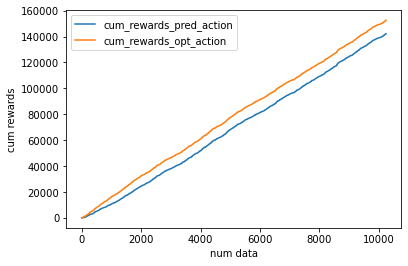

In [53]:
import matplotlib.pyplot as plt
plt.plot(cum_rewards_pred_action, label = 'cum_rewards_pred_action')
plt.plot(cum_rewards_opt_action, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

In [48]:
np.sum(pred_actions == opt_actions)/num_data_train

1024